In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import xgboost as xgb
from sklearn.impute import SimpleImputer

# Models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier
plt.style.use('default')

#-i https://pypi.tuna.tsinghua.edu.cn/simple/

<span style="font-size: 20px;">导入原始数据，先进行数据探索性分析

In [6]:
#导入数据，查看缺失值
df = pd.read_csv(r'E:\Study\统计建模\python\data\thyroid_cancer_risk_data.csv')
print("检查缺失值\n",df.isnull().sum())
df= df.drop(['Patient_ID'], axis=1)
df.head()


检查缺失值
 Patient_ID             0
Age                    0
Gender                 0
Country                0
Ethnicity              0
Family_History         0
Radiation_Exposure     0
Iodine_Deficiency      0
Smoking                0
Obesity                0
Diabetes               0
TSH_Level              0
T3_Level               0
T4_Level               0
Nodule_Size            0
Thyroid_Cancer_Risk    0
Diagnosis              0
dtype: int64


,Age,Gender,Country,Ethnicity,Family_History,Radiation_Exposure,Iodine_Deficiency,Smoking,Obesity,Diabetes,TSH_Level,T3_Level,T4_Level,Nodule_Size,Thyroid_Cancer_Risk,Diagnosis
0,66,Male,Russia,Caucasian,No,Yes,No,No,No,No,9.37,1.67,6.16,1.08,Low,Benign
1,29,Male,Germany,Hispanic,No,Yes,No,No,No,No,1.83,1.73,10.54,4.05,Low,Benign
2,86,Male,Nigeria,Caucasian,No,No,No,No,No,No,6.26,2.59,10.57,4.61,Low,Benign
3,75,Female,India,Asian,No,No,No,No,No,No,4.10,2.62,11.04,2.46,Medium,Benign
4,35,Female,Germany,African,Yes,Yes,No,No,No,No,9.10,2.11,10.71,2.11,High,Benign


In [15]:
min(df['Age'])

15

<span style="font-size: 20px;">导入原始数据，先进行数据探索性分析，首先发现了样本不平衡问题

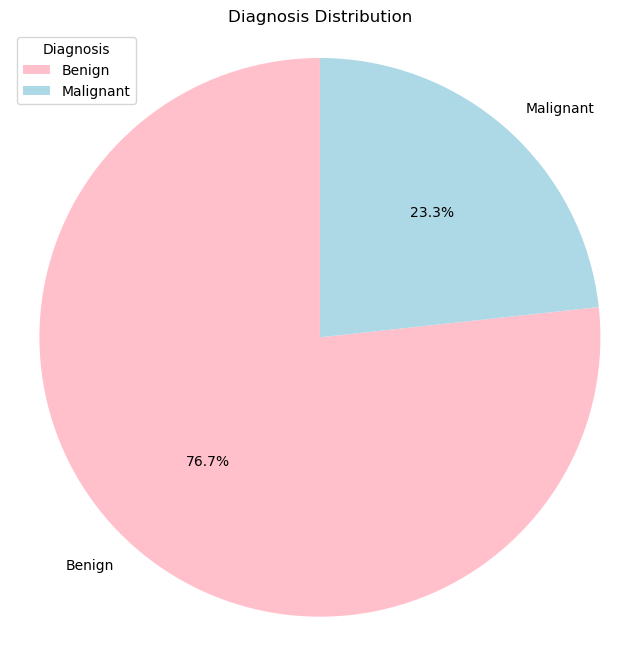

In [29]:
Diagnosis_counts = df['Diagnosis'].value_counts()

plt.figure(figsize=(8, 8))
plt.pie(Diagnosis_counts.values, labels=Diagnosis_counts.index, autopct='%1.1f%%', startangle=90, colors=['pink','lightblue'])
plt.title('Diagnosis Distribution')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle
plt.legend(title="Diagnosis")
plt.show()

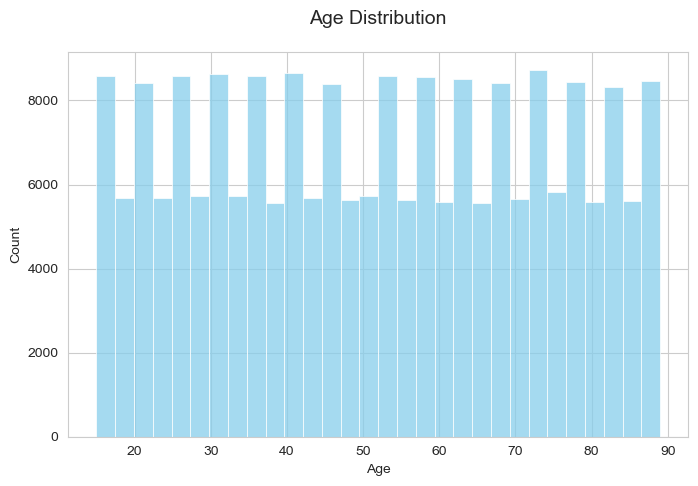

In [16]:
#年龄分布
import seaborn as sns
import matplotlib.pyplot as plt

# 设置Seaborn主题和配色（简洁白色网格+柔和色调）
sns.set_style("whitegrid")
sns.set_palette("pastel")

plt.figure(figsize=(8, 5))
ax = sns.histplot(df['Age'], bins=30, 
                 color='skyblue', edgecolor='white',
                 line_kws={'linewidth': 2, 'color': 'salmon'},  # 控制KDE曲线
                 linewidth=0.5)  # 控制直方图边框
plt.title("Age Distribution", fontsize=14, pad=20)
plt.show()
#, kde=True#

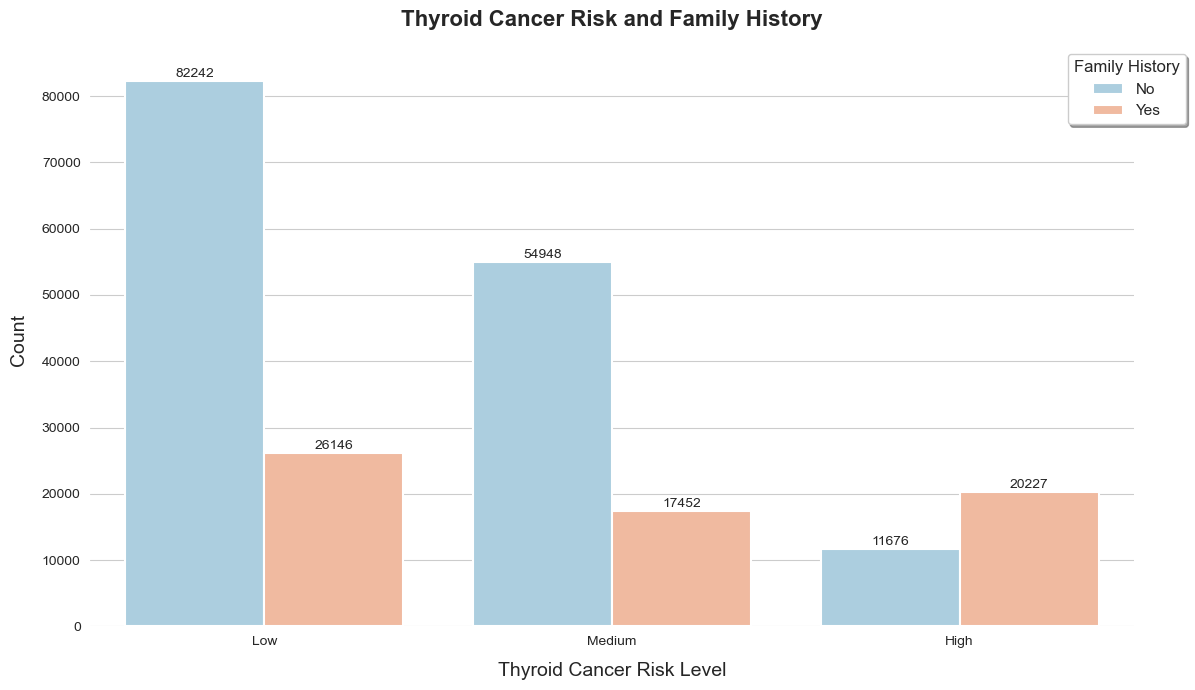

In [54]:
#甲状腺癌家族史与患癌风险
plt.figure(figsize=(12, 7))  # 增大画布尺寸[2,7](@ref)
sns.set_style("whitegrid")  # 设置白色网格背景[2,3](@ref)
# sns.set_palette("plasma")  # 全局调色板设置[6](@ref)

ax = sns.countplot(
    data=df,
    x='Thyroid_Cancer_Risk',
    hue='Family_History',
    palette='RdBu_r',
    saturation=0.85,  # 调整颜色饱和度[6](@ref)
    edgecolor='white',  # 添加白色边框[7](@ref)
    linewidth=1.5  # 边框粗细[7](@ref)
)

# 标题和标签美化
plt.title('Thyroid Cancer Risk and Family History', 
          fontsize=16, pad=20, weight='bold')  # 加粗标题并增加间距[2](@ref)
plt.xlabel('Thyroid Cancer Risk Level', fontsize=14, labelpad=10)  # 增加标签间距[7](@ref)
plt.ylabel('Count', fontsize=14, labelpad=10)  # 更专业的Y轴标签[7](@ref)

# 图例美化
plt.legend(
    title='Family History',
    title_fontsize=12,
    fontsize=11,
    frameon=True,
    shadow=True,  # 添加阴影[3](@ref)
    bbox_to_anchor=(1.05, 1),  # 将图例移到图表右侧[3](@ref)
    borderaxespad=0
)

# 添加数据标签
for p in ax.patches:
    ax.annotate(
        f'{int(p.get_height())}', 
        (p.get_x() + p.get_width() / 2., p.get_height()),
        ha='center', va='center', 
        xytext=(0, 5), 
        textcoords='offset points',
        fontsize=10
    )

# 移除多余的边框
sns.despine(left=True, bottom=True)  # 保留网格线但移除坐标轴线[3](@ref)

# 调整布局
plt.tight_layout()  # 自动调整元素间距[2](@ref)
plt.show()

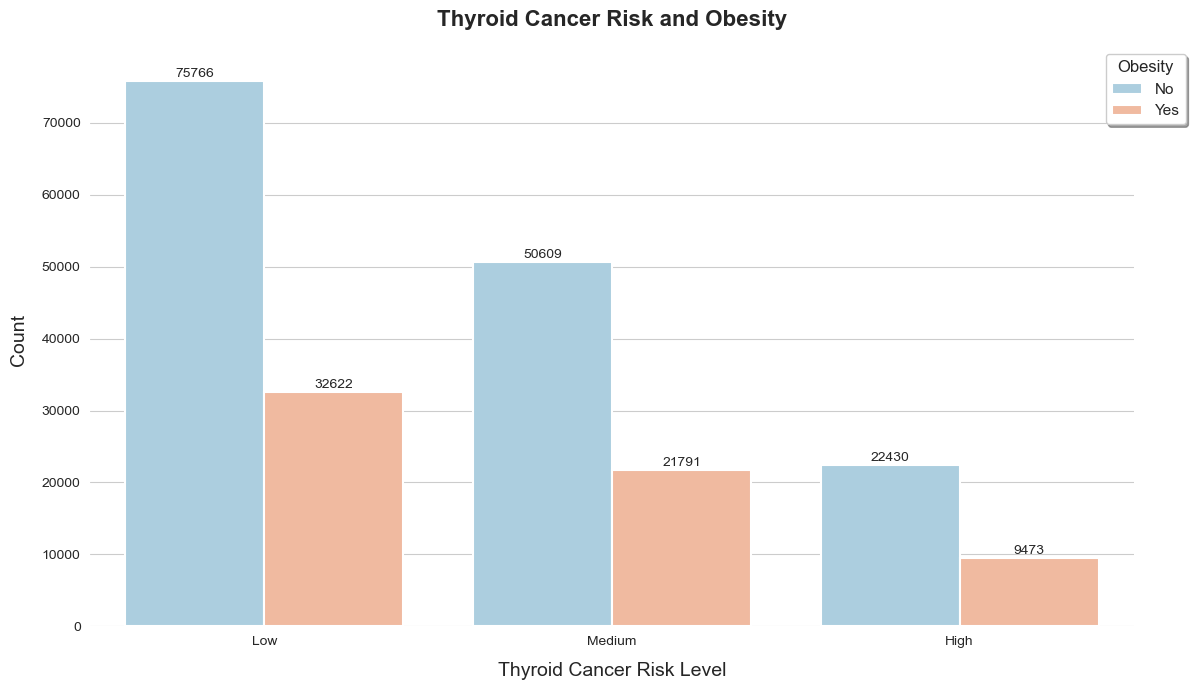

In [68]:
#患癌风险与肥胖
plt.figure(figsize=(12, 7))  # 增大画布尺寸[2,7](@ref)
sns.set_style("whitegrid")  # 设置白色网格背景[2,3](@ref)
# sns.set_palette("plasma")  # 全局调色板设置[6](@ref)

ax = sns.countplot(
    data=df,
    x='Thyroid_Cancer_Risk',
    hue='Obesity',
    palette='RdBu_r',
    saturation=0.85,  # 调整颜色饱和度[6](@ref)
    edgecolor='white',  # 添加白色边框[7](@ref)
    linewidth=1.5,
    hue_order=['No', 'Yes']  # 关键修改# 边框粗细[7](@ref)
)

# 标题和标签美化
plt.title('Thyroid Cancer Risk and Obesity', 
          fontsize=16, pad=20, weight='bold')  # 加粗标题并增加间距[2](@ref)
plt.xlabel('Thyroid Cancer Risk Level', fontsize=14, labelpad=10)  # 增加标签间距[7](@ref)
plt.ylabel('Count', fontsize=14, labelpad=10)  # 更专业的Y轴标签[7](@ref)

# 图例美化
plt.legend(
    title='Obesity',
    title_fontsize=12,
    fontsize=11,
    frameon=True,
    shadow=True,  # 添加阴影[3](@ref)
    bbox_to_anchor=(1.05, 1),  # 将图例移到图表右侧[3](@ref)
    borderaxespad=0
)

# 添加数据标签
for p in ax.patches:
    ax.annotate(
        f'{int(p.get_height())}', 
        (p.get_x() + p.get_width() / 2., p.get_height()),
        ha='center', va='center', 
        xytext=(0, 5), 
        textcoords='offset points',
        fontsize=10
    )

# 移除多余的边框
sns.despine(left=True, bottom=True)  # 保留网格线但移除坐标轴线[3](@ref)

# 调整布局
plt.tight_layout()  # 自动调整元素间距[2](@ref)
plt.show()

<span style="font-size: 20px;">下面进行数据预处理，Country	Ethnicity这两个变量比较难处理的入手，考虑是否剔除

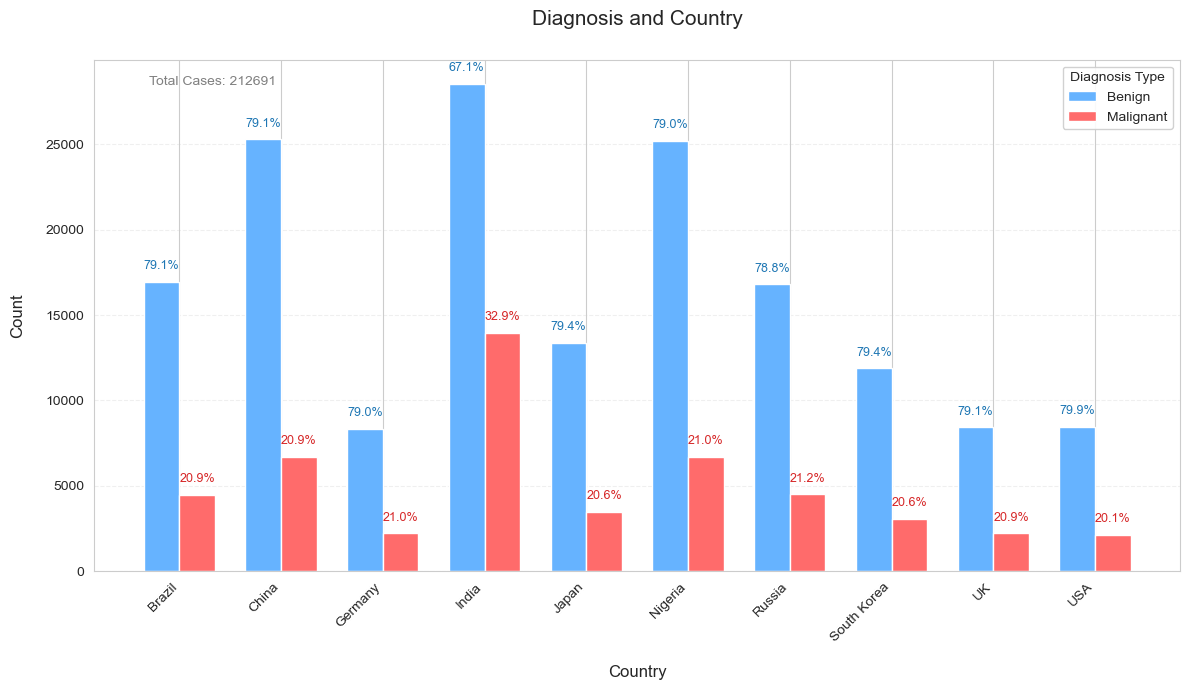

In [69]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# 数据预处理：统计各国家不同诊断结果的数量
counts = df.groupby(['Country', 'Diagnosis']).size().unstack(fill_value=0)

# 计算国家维度总病例数（用于计算比率）
country_totals = counts.sum(axis=1)
benign_ratio = (counts['Benign'] / country_totals * 100).round(1)
malignant_ratio = (counts['Malignant'] / country_totals * 100).round(1)

# 设置绘图参数
bar_width = 0.35
index = np.arange(len(counts.index))
colors = {'Benign': '#66b3ff', 'Malignant': '#ff6b6b'}

# 创建画布
plt.figure(figsize=(12, 7))

# 绘制分组柱状图
benign_bars = plt.bar(index - bar_width/2, counts['Benign'], width=bar_width,
                     color=colors['Benign'], label='Benign')
malignant_bars = plt.bar(index + bar_width/2, counts['Malignant'], width=bar_width,
                        color=colors['Malignant'], label='Malignant')

for i, (br, mr) in enumerate(zip(benign_ratio, malignant_ratio)):
    # 修改后的索引方式
    plt.text(x=index[i] - bar_width/2, 
             y=counts['Benign'].iloc[i] + max(counts.max())*0.02,  # 使用.iloc
             s=f'{br}%',
             ha='center', va='bottom', fontsize=9, color='#1f77b4')
    
    plt.text(x=index[i] + bar_width/2,
             y=counts['Malignant'].iloc[i] + max(counts.max())*0.02,  # 使用.iloc
             s=f'{mr}%', 
             ha='center', va='bottom', fontsize=9, color='#d62728')

# 增强图表元素
plt.title('Diagnosis and Country', fontsize=15, pad=25)
plt.xlabel('Country', fontsize=12, labelpad=15)
plt.ylabel('Count', fontsize=12, labelpad=15)
plt.xticks(index, counts.index, rotation=45, ha='right')  # 优化国家标签显示
plt.legend(title='Diagnosis Type', framealpha=0.9)
plt.grid(axis='y', alpha=0.3, linestyle='--')

# 添加辅助说明（网页6建议的布局优化）
plt.annotate(f'Total Cases: {country_totals.sum()}', 
            xy=(0.05, 0.95), xycoords='axes fraction',
            fontsize=10, color='gray')

# 调整布局
plt.tight_layout()
plt.show()

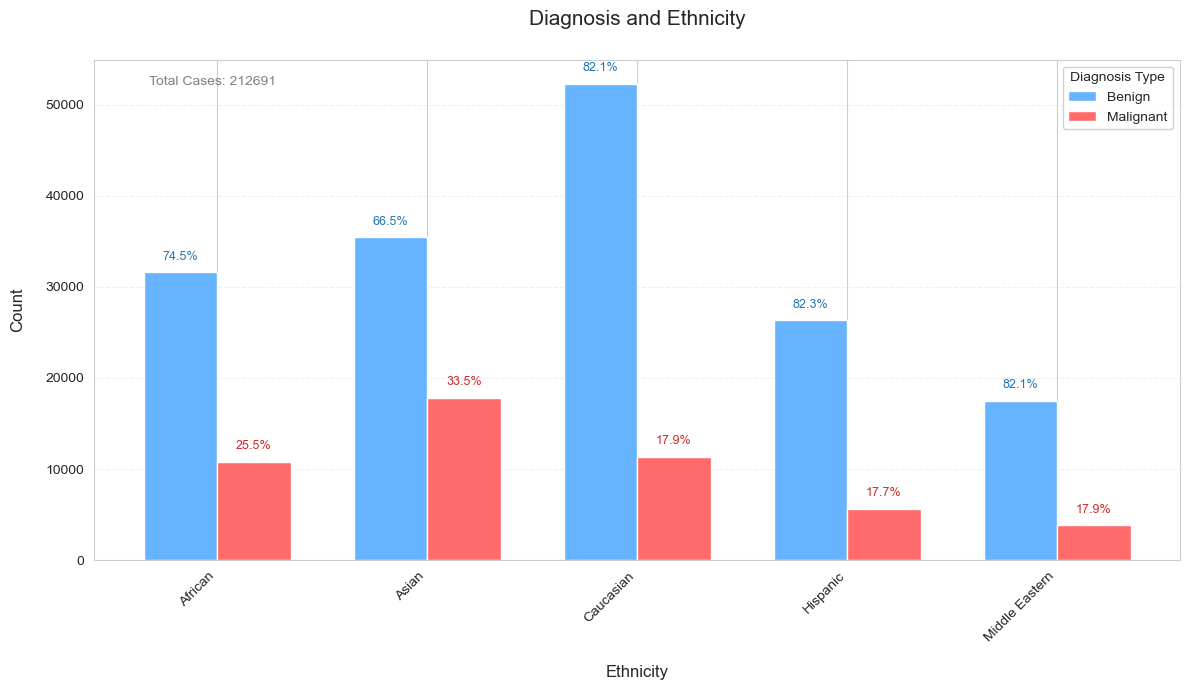

In [70]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np


counts = df.groupby(['Ethnicity', 'Diagnosis']).size().unstack(fill_value=0)

# 计算国家维度总病例数（用于计算比率）
country_totals = counts.sum(axis=1)
benign_ratio = (counts['Benign'] / country_totals * 100).round(1)
malignant_ratio = (counts['Malignant'] / country_totals * 100).round(1)

# 设置绘图参数
bar_width = 0.35
index = np.arange(len(counts.index))
colors = {'Benign': '#66b3ff', 'Malignant': '#ff6b6b'}

# 创建画布
plt.figure(figsize=(12, 7))

# 绘制分组柱状图
benign_bars = plt.bar(index - bar_width/2, counts['Benign'], width=bar_width,
                     color=colors['Benign'], label='Benign')
malignant_bars = plt.bar(index + bar_width/2, counts['Malignant'], width=bar_width,
                        color=colors['Malignant'], label='Malignant')

for i, (br, mr) in enumerate(zip(benign_ratio, malignant_ratio)):
    # 修改后的索引方式
    plt.text(x=index[i] - bar_width/2, 
             y=counts['Benign'].iloc[i] + max(counts.max())*0.02,  # 使用.iloc
             s=f'{br}%',
             ha='center', va='bottom', fontsize=9, color='#1f77b4')
    
    plt.text(x=index[i] + bar_width/2,
             y=counts['Malignant'].iloc[i] + max(counts.max())*0.02,  # 使用.iloc
             s=f'{mr}%', 
             ha='center', va='bottom', fontsize=9, color='#d62728')

# 增强图表元素
plt.title('Diagnosis and Ethnicity', fontsize=15, pad=25)
plt.xlabel('Ethnicity', fontsize=12, labelpad=15)
plt.ylabel('Count', fontsize=12, labelpad=15)
plt.xticks(index, counts.index, rotation=45, ha='right')  # 优化国家标签显示
plt.legend(title='Diagnosis Type', framealpha=0.9)
plt.grid(axis='y', alpha=0.3, linestyle='--')

# 添加辅助说明（网页6建议的布局优化）
plt.annotate(f'Total Cases: {country_totals.sum()}', 
            xy=(0.05, 0.95), xycoords='axes fraction',
            fontsize=10, color='gray')

# 调整布局
plt.tight_layout()
plt.show()

<span style="font-size: 20px;">India为1，其他为0。Asian为1，其他为0。

In [18]:
cols_config = {'Country': ('India', 1), 'Ethnicity': ('Asian', 1)}
for col, (condition, value) in cols_config.items():
    df[col] = np.where(df[col]==condition, value, 0)
df.head()

,Age,Gender,Country,Ethnicity,Family_History,Radiation_Exposure,Iodine_Deficiency,Smoking,Obesity,Diabetes,TSH_Level,T3_Level,T4_Level,Nodule_Size,Thyroid_Cancer_Risk,Diagnosis
0,66,Male,0,0,No,Yes,No,No,No,No,9.37,1.67,6.16,1.08,Low,Benign
1,29,Male,0,0,No,Yes,No,No,No,No,1.83,1.73,10.54,4.05,Low,Benign
2,86,Male,0,0,No,No,No,No,No,No,6.26,2.59,10.57,4.61,Low,Benign
3,75,Female,1,1,No,No,No,No,No,No,4.10,2.62,11.04,2.46,Medium,Benign
4,35,Female,0,0,Yes,Yes,No,No,No,No,9.10,2.11,10.71,2.11,High,Benign


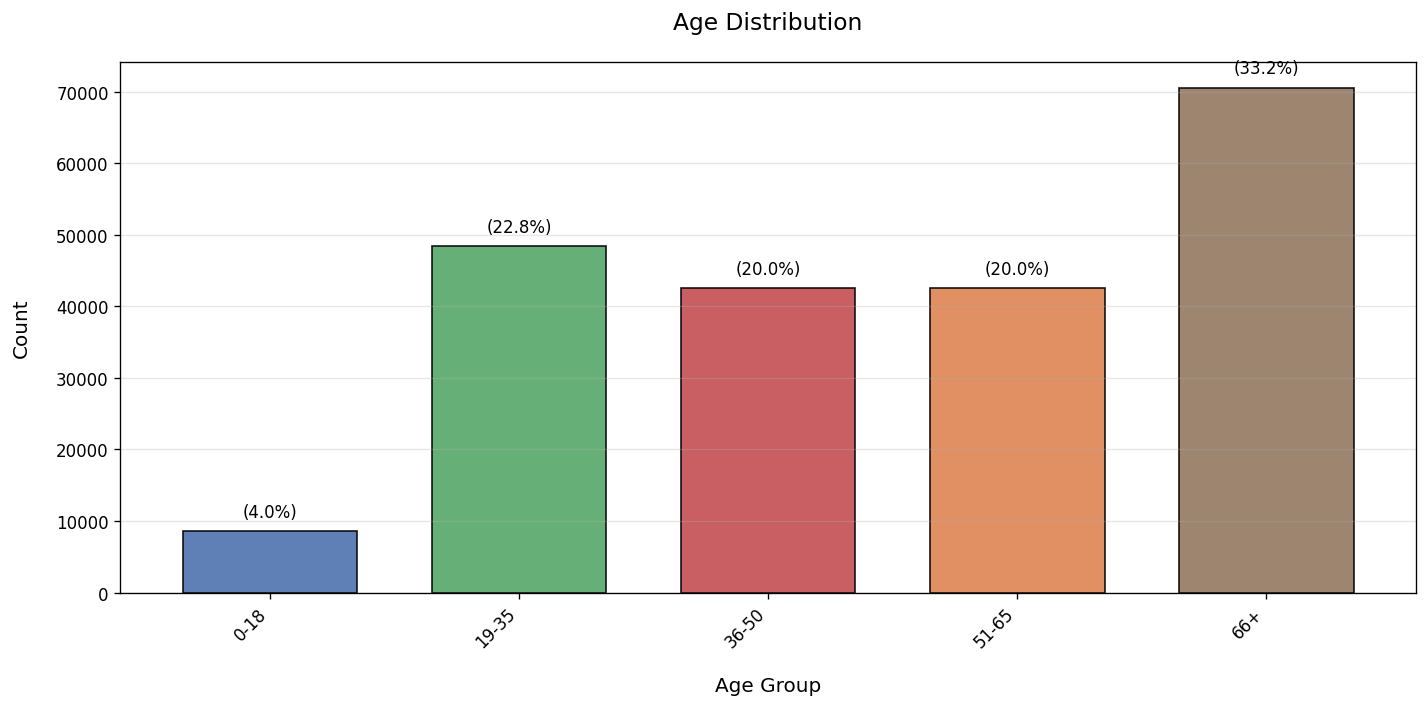

In [19]:
#1. 数据分组与顺序控制
bins = [0, 18, 35, 50, 65, 100]
labels = ['0-18', '19-35', '36-50', '51-65', '66+']

# 创建有序分类类型（关键步骤）
df['AgeGroup'] = pd.cut(
    df['Age'], 
    bins=bins, 
    labels=labels,
    right=False,  # 左闭右开区间（例如 18 岁属于 0-18 组）
    ordered=False
).astype(pd.CategoricalDtype(categories=labels, ordered=True))  # 强制固定顺序

# 2. 按指定顺序统计频数
age_counts = df['AgeGroup'].value_counts().sort_index()  # 按分类顺序排序
total = age_counts.sum()
age_percent = (age_counts / total * 100).round(1)

# 3. 可视化优化
plt.figure(figsize=(12, 6), dpi=120)
ax = age_counts.plot(kind='bar', 
                     color=['#4C72B0', '#55A868', '#C44E52', '#DD8452', '#937860'],
                     width=0.7,
                     edgecolor='black',
                     alpha=0.9)

# 添加数据标签（仅百分比）
for i, (count, percent) in enumerate(zip(age_counts, age_percent)):
    ax.text(i, count + max(age_counts)*0.02, 
            f'({percent}%)', 
            ha='center', va='bottom', 
            fontsize=10, color='black')

# 图表装饰
plt.title('Age Distribution', fontsize=14, pad=20)
plt.xlabel('Age Group', fontsize=12, labelpad=15)
plt.ylabel('Count', fontsize=12, labelpad=15)
plt.xticks(rotation=45, ha='right')  # 标签右对齐防重叠
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

<span style="font-size: 20px;">离散型→数值化，基本都是0，1。但特别的Age分组

In [20]:
#处理Age
# 定义分箱边界和标签
bins = [0, 18, 35, 50, 65, 100]
labels = ['0-18', '19-35', '36-50', '51-65', '66+']

# 生成分组列
df['AgeGroup'] = pd.cut(df['Age'], 
                        bins=bins, 
                        labels=labels,
                        right=False)  # 左闭右开区间[1,3](@ref)
# 创建映射字典
mapping = {
    '0-18': 0,
    '19-35': 1,
    '36-50': 2,
    '51-65': 3,
    '66+': 4
}

# 方法一：使用 map 函数
df['Age'] = df['AgeGroup'].map(mapping)
df = df.drop(columns=['AgeGroup'])

In [21]:
# 处理其他离散型变量
mapping_dict = {
    "Gender":{"Male": 1, "Female": 0},
    "Family_History": {"Yes": 1, "No": 0},
    "Radiation_Exposure": {"Yes": 1, "No": 0},
    "Iodine_Deficiency": {"Yes": 1, "No": 0},
    "Smoking": {"Yes": 1, "No": 0},
    "Obesity": {"Yes": 1, "No": 0},
    "Diabetes": {"Yes": 1, "No": 0},
    "Thyroid_Cancer_Risk": {"Low": 0, "Medium": 1, "High": 2},
    "Diagnosis": {"Benign": 0, "Malignant": 1}
}

for column, mapping in mapping_dict.items():
    if column in df.columns:
        df[column] = df[column].map(mapping)

# Scale numerical features 标准化
scaler = StandardScaler()
numerical_cols = ['TSH_Level', 'T3_Level', 'T4_Level', 'Nodule_Size']
df[numerical_cols] = scaler.fit_transform(df[numerical_cols])
df.head()

,Age,Gender,Country,Ethnicity,Family_History,Radiation_Exposure,Iodine_Deficiency,Smoking,Obesity,Diabetes,TSH_Level,T3_Level,T4_Level,Nodule_Size,Thyroid_Cancer_Risk,Diagnosis
0,4,1,0,0,0,1,0,0,0,0,1.512066,-0.382947,-0.963968,-0.985308,0,0
1,1,1,0,0,0,1,0,0,0,0,-1.124060,-0.313683,1.059890,1.070585,0,0
2,4,1,0,0,0,0,0,0,0,0,0.424751,0.679107,1.073752,1.458229,0,0
3,4,0,1,1,0,0,0,0,0,0,-0.330426,0.713739,1.290924,-0.030045,1,0
4,2,0,0,0,1,1,0,0,0,0,1.417669,0.124991,1.138441,-0.272322,2,0


In [ ]:
df.to_csv('newdata.csv')

<span style="font-size: 20px;">基于潜空间，进行探索性分析



In [4]:
#导入数据，查看缺失值
df = pd.read_csv(r'E:\Study\统计建模\python\data\data with AE(latent dim=6).csv')

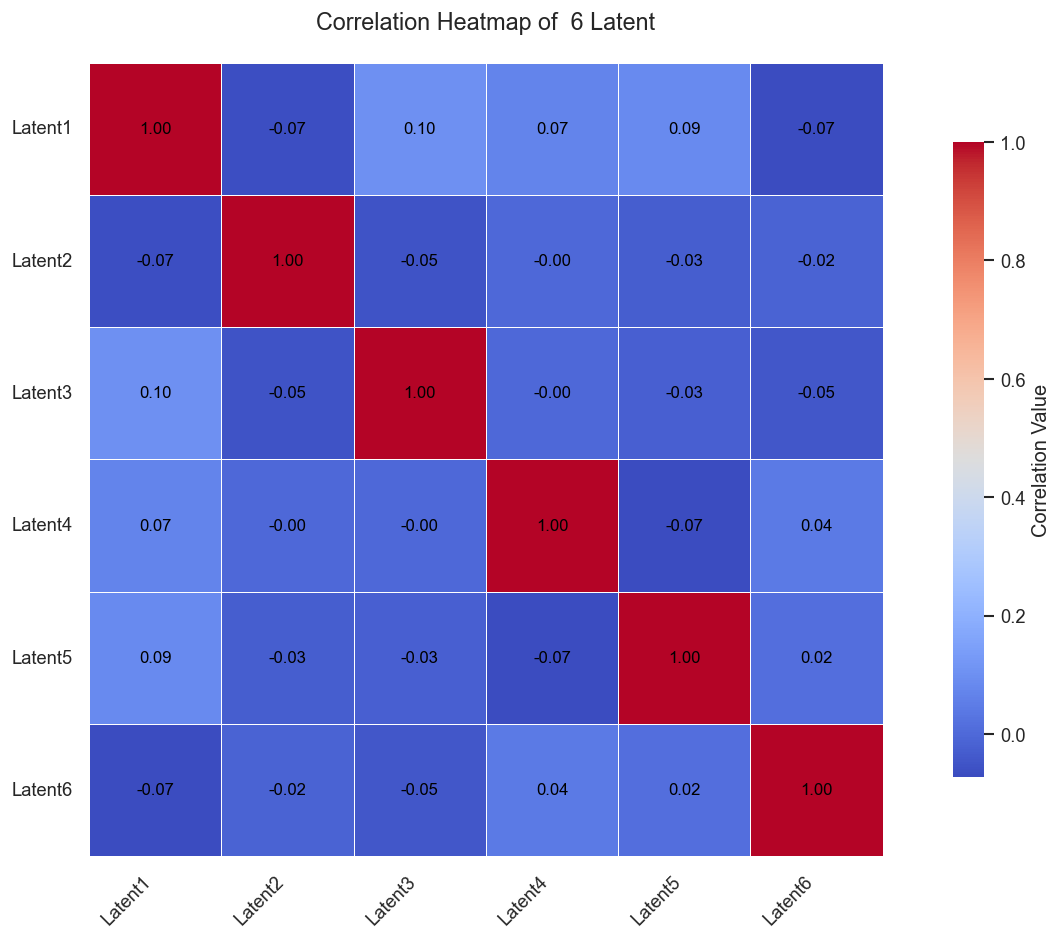

In [7]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# 选择前6列数据（处理缺失值后）
data = df.iloc[:, :6]

# 创建画布与样式设置
plt.figure(figsize=(12, 8), dpi=120)  # 高清画布
sns.set_theme(style="whitegrid")      # 设置主题

# 生成热力图
heatmap = sns.heatmap(
    data.corr(),                      # 计算相关系数矩阵
    annot=True,                       # 显示数值
    fmt=".2f",                        # 保留两位小数
    cmap="coolwarm",                  # 蓝-红渐变配色
    linewidths=0.5,                   # 单元格间隔线
    linecolor="white",                # 间隔线颜色
    square=True,                      # 保持单元格为正方形
    cbar_kws={
        "shrink": 0.8,                # 缩短颜色条长度
        "label": "Correlation Value"   # 颜色条标签
    },
    annot_kws={
        "size": 10,                   # 注释字体大小
        "color": "black"              # 字体颜色
    }
)

# 高级美化设置
plt.title("Correlation Heatmap of  6 Latent", 
          fontsize=14, pad=20)        # 标题与间距
plt.xticks(rotation=45, ha='right')   # X轴标签旋转45度
plt.yticks(rotation=0)                # Y轴标签水平显示
heatmap.figure.tight_layout()         # 自动调整布局

plt.show()

C:\Users\Yewan\AppData\Local\Temp\ipykernel_26584\2021138981.py:68: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  cbar = plt.colorbar(sm, pad=0.02, aspect=40)


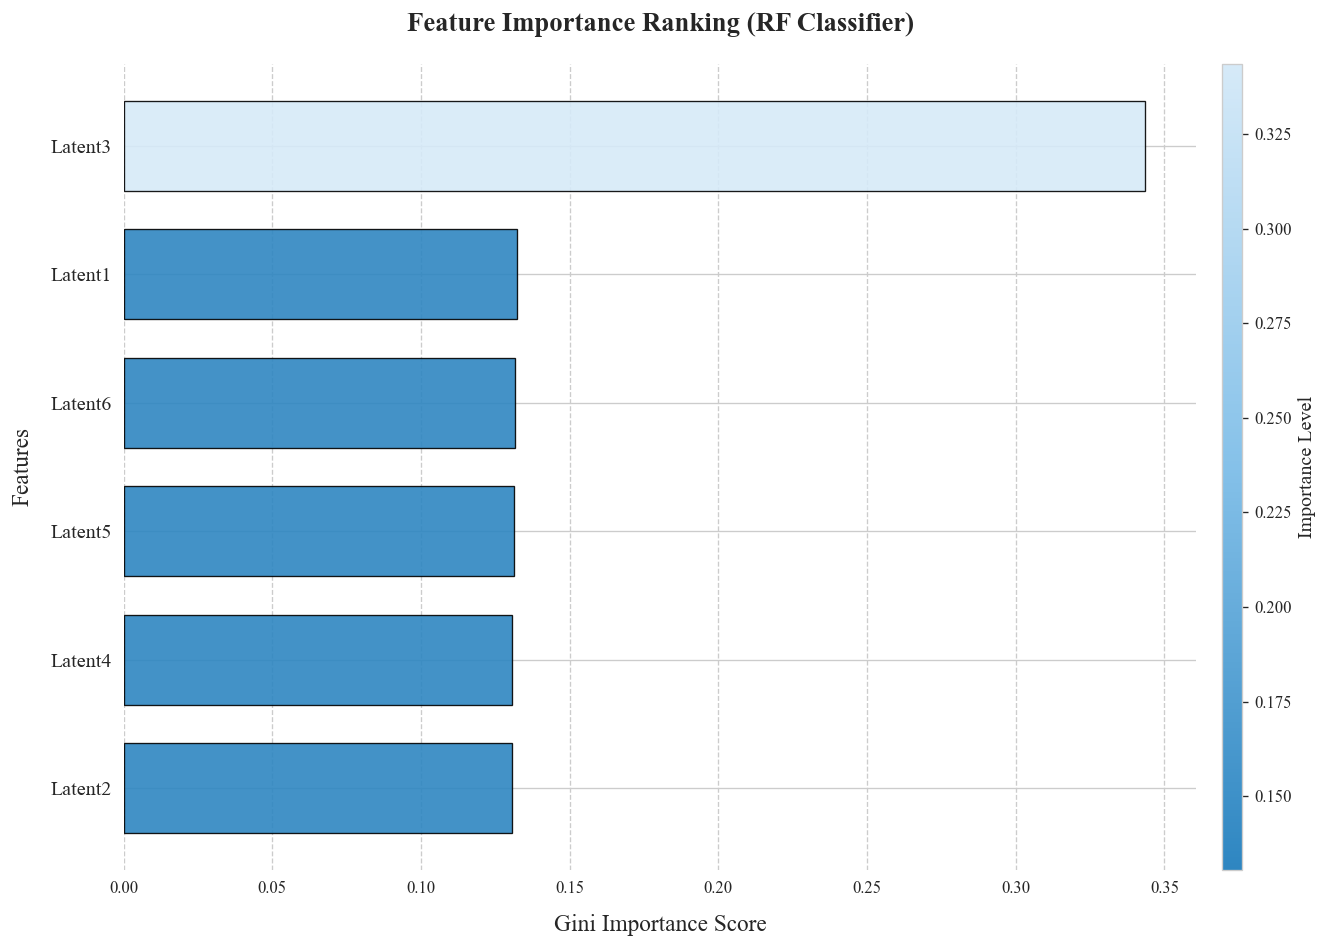

In [5]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils.class_weight import compute_class_weight 
X = df.drop(columns=['Diagnosis']).values
y = df['Diagnosis'].values
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
#样本不平衡 加权
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights_dict = dict(enumerate(class_weights))  # 转换为字典格式[5](@ref)

# 随机森林建模
model = RandomForestClassifier()
model.fit(X_train, y_train)
# 提取特征名称和重要性
feature_names = df.drop(columns=['Diagnosis']).columns
importances = model.feature_importances_

# 创建排序后的元组列表
sorted_indices = np.argsort(importances)[::-1]  # 降序排列
sorted_features = [feature_names[i] for i in sorted_indices]
sorted_importances = importances[sorted_indices]

# 可视化设置
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from matplotlib.colors import LinearSegmentedColormap
# 设置Seaborn风格（提升整体美观性）
sns.set_style("whitegrid")
plt.rcParams['font.family'] = 'Times New Roman'  # 学术字体

# 自定义渐变色（参考网页1、3、5的配色建议）
colors = ["#2E86C1", "#85C1E9", "#D6EAF8"]  # 蓝白渐变
cmap = LinearSegmentedColormap.from_list("custom_blue", colors)

# 生成渐变色数组（根据重要性值映射颜色）
norm = plt.Normalize(min(sorted_importances), max(sorted_importances))
colors = [cmap(norm(v)) for v in sorted_importances]

# 可视化设置
plt.figure(figsize=(12, 8), dpi=120)
bars = plt.barh(range(len(sorted_features)), sorted_importances, 
                color=colors, edgecolor='black', linewidth=0.8, height=0.7,
                alpha=0.9,  # 微调透明度（网页3建议）
                zorder=3)  # 图层层级

# 坐标轴与标签美化（参考网页6、7的标注技巧）
plt.yticks(range(len(sorted_features)), sorted_features, fontsize=12)
plt.gca().invert_yaxis()  # 重要特征置顶
plt.title("Feature Importance Ranking (RF Classifier)", 
          fontsize=16, pad=20, weight='bold')  # 标题加粗（网页7建议）
plt.xlabel("Gini Importance Score", fontsize=14, labelpad=10)
plt.ylabel("Features", fontsize=14, labelpad=10)

# 网格与边框优化（网页6的细节处理）
plt.grid(axis='x', color='gray', linestyle='--', alpha=0.4, zorder=1)
sns.despine(left=True, bottom=True)  # 移除坐标轴边框（网页6技巧）

# 添加数值标签（动态调整文字颜色对比度）
# for i, v in enumerate(sorted_importances):
#     text_color = 'white' if norm(v) > 0.7 else 'black'  # 高重要性值用白字（网页5建议）
#     plt.text(v + 0.003, i, f"{v:.3f}", 
#              color=text_color, va='center', fontsize=10, weight='bold')

# 添加渐变色图例（网页3的色带设计）
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, pad=0.02, aspect=40)
cbar.set_label('Importance Level', fontsize=12)

plt.tight_layout()
plt.show()
